In [ ]:
!pip install autogluon matplotlib

# Config

In [14]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = None
presets = None#'best_quality'

use_is_estimated_attr = True

num_seeds = 3

drop_night_outliers = True

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]


num_stack_levels = 0
num_bag_folds = 4# 8
num_bag_sets = 1#20

use_tune_data = True
use_test_data = False
use_bag_holdout = True # Enable this if there is a large gap between score_val and score_test in stack models. 

clip_predictions = True

# Loading and preprocessing

In [15]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
               'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
               'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

    # Filter rows where index.minute == 0
    X_no_mean = X[X.index.minute == 0][columns].copy()

    date_calc = None
    # If 'date_calc' is present, handle it
    if 'date_calc' in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']

    X = X.resample('H').mean()

    X[columns] = X_no_mean[columns]

    if date_calc is not None:
        X['date_calc'] = date_calc
    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)
    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1


    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")

    print(f"Size of estimated after dropping nans: {len(X_train[X_train['is_estimated']==1].dropna(subset=['y']))}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in y: 0
Size of estimated after dropping nans: 4418
Processing location B...
Number of nans in y: 4
Size of estimated after dropping nans: 3625
Processing location C...
Number of nans in y: 6059
Size of estimated after dropping nans: 2954


## Feature enginering

### Remove anomalies

In [16]:
def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]
            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}


In [17]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))


Dropped rows:  9285


In [18]:
thresh = 0.1
mask = (X_train["direct_rad_1h:J"] <= thresh) & (X_train["diffuse_rad_1h:J"] <= thresh) & (X_train["y"] >= 0.1)
if drop_night_outliers:
    X_train.loc[mask, "y"] = np.nan

In [19]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))

Dropped rows:  1876


In [20]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [21]:
from sklearn.model_selection import train_test_split
def strat_split(x, test_size=0.2, seed=42):
    # create stratified column, location, week, y (mapped to boolean, 0 or bigger)
    strat = x["location"] + "_" + x["ds"].dt.week.astype('str') + "_" + x["y"].apply(lambda x: 0 if x == 0 else 1).astype('str')
    #print(x["strat"])
    print(f"Number of unique strats: {len(strat.unique())}")
    print(f"Lengt of strat: {len(strat)}")

    # check if there are any strats with only one row
    for s in strat.unique():
        if len(x[strat == s]) == 1:
            print(f"Strat {s} has only one row")
            # set equal to another strat with more rows
            strat[strat == s] = strat.unique()[0]

    # split
    train, test = train_test_split(x, test_size=test_size, random_state=seed, stratify=strat)
    

    return train, test


In [22]:
from autogluon.tabular import TabularDataset, TabularPredictor
data = TabularDataset('X_train_raw.csv')
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_sets = [pd.DataFrame()]*num_seeds
tune_sets = [pd.DataFrame()]*num_seeds
new_train_sets = [pd.DataFrame()]*num_seeds


for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    # 3 different seeds
    for i in range(num_seeds):
        holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])
    
        loc_new_train_set, loc_tune_set = strat_split(estimated_set[estimated_set["location"] == location], holdout_frac, seed=i)
        new_train_sets[i] = pd.concat([new_train_sets[i], loc_new_train_set])

        if use_test_data:
            loc_tune_set, loc_test_set = strat_split(loc_tune_set, 0.2, seed=i+1)
            test_sets[i] = pd.concat([test_sets[i], loc_test_set])

        tune_sets[i] = pd.concat([tune_sets[i], loc_tune_set])


train_data_list = [pd.concat([train_set, new_train_set]) for new_train_set in new_train_sets]
tuning_data_list = tune_sets
    
test_data_list = [pd.DataFrame()]*num_seeds
if use_test_data:
    test_data_list = test_sets
    for i in range(num_seeds):
        print("Shape of test", test_data_list[i].shape[0])


train_data_list = [TabularDataset(train_data) for train_data in train_data_list]
tuning_data_list = [TabularDataset(tuning_data) for tuning_data in tuning_data_list]

if use_test_data:
    test_data_list = [TabularDataset(test_data) for test_data in test_data_list]

Loaded data from: X_train_raw.csv | Columns = 46 / 46 | Rows = 87925 -> 87925


Number of unique strats: 54
Lengt of strat: 4216
Number of unique strats: 54
Lengt of strat: 4216
Number of unique strats: 54
Lengt of strat: 4216
Number of unique strats: 49
Lengt of strat: 3535
Number of unique strats: 49
Lengt of strat: 3535
Number of unique strats: 49
Lengt of strat: 3535
Number of unique strats: 46
Lengt of strat: 2925
Number of unique strats: 46
Lengt of strat: 2925
Number of unique strats: 46
Lengt of strat: 2925


# Modeling

In [23]:
import os

# if submissions folder does not exist, create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

print("New filename:", new_filename)

Last submission number: 132
Now creating submission number: 133
New filename: submission_133


In [24]:
predictors = [None, None, None]

In [25]:
# to mean ensemble different seeds
class NaiveEnsemble:
    def __init__(self, predictors):
        self.predictors = predictors

    def predict(self, x):
        predictions = []
        for predictor in self.predictors:
            predictions.append(predictor.predict(x))
        return np.mean(predictions, axis=0)

In [26]:
from autogluon.common import space
def fit_predictor_for_location(loc):
    different_seeds_predictors = []
    for i, (train_data, tuning_data, test_data) in enumerate(zip(train_data_list, tuning_data_list, test_data_list)):
        print(f"Training model for location {loc}, seed {i}...")

        hyperparameters = {
            'NN_TORCH': {},
            'XT': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
            'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}],#, {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}],
            'FASTAI': {},
            'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
        }



        predictor = TabularPredictor(
            label=label, 
            eval_metric=metric, 
            path=f"AutogluonModels/{new_filename}_{loc}_seed_{i}", 
        ).fit(
            train_data=train_data[train_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
            time_limit=time_limit, 
            presets=presets, 
            num_stack_levels=num_stack_levels,
            num_bag_folds=num_bag_folds,
            num_bag_sets=num_bag_sets,
            tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
            use_bag_holdout=use_bag_holdout,
            hyperparameters=hyperparameters,
            #hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
            excluded_model_types=["XT"] if loc == "C" else ["KNN"] if loc=="B" else ["KNN", "XT"]
        )

        # evaluate on test data
        if use_test_data:
            t = test_data[test_data["location"] == loc]
            perf = predictor.evaluate(t)
            print("Evaluation on test data:")
            print(perf[predictor.eval_metric.name])

        different_seeds_predictors.append(predictor)

    return NaiveEnsemble(different_seeds_predictors)

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_A_seed_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   113.64 GB / 494.38 GB (23.0%)
Train Data Rows:    31283
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 668.96033, 1193.25339)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting 

Training model for location A, seed 0...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):

[1000]	valid_set's l1: 186.795
[2000]	valid_set's l1: 179.852
[3000]	valid_set's l1: 176.284
[4000]	valid_set's l1: 174.52
[5000]	valid_set's l1: 173.313
[6000]	valid_set's l1: 172.465
[7000]	valid_set's l1: 171.922
[8000]	valid_set's l1: 171.46
[9000]	valid_set's l1: 171.077
[10000]	valid_set's l1: 170.846
[1000]	valid_set's l1: 179.581
[2000]	valid_set's l1: 174.837
[3000]	valid_set's l1: 172.123
[4000]	valid_set's l1: 170.34
[5000]	valid_set's l1: 169.519
[6000]	valid_set's l1: 169.152
[7000]	valid_set's l1: 168.552
[8000]	valid_set's l1: 168.137
[9000]	valid_set's l1: 167.78
[10000]	valid_set's l1: 167.564
[1000]	valid_set's l1: 184.43
[2000]	valid_set's l1: 178.208
[3000]	valid_set's l1: 175.162
[4000]	valid_set's l1: 172.96
[5000]	valid_set's l1: 171.722
[6000]	valid_set's l1: 171.075
[7000]	valid_set's l1: 170.625
[8000]	valid_set's l1: 170.051
[9000]	valid_set's l1: 169.724
[10000]	valid_set's l1: 169.322
[1000]	valid_set's l1: 187.138
[2000]	valid_set's l1: 181.284
[3000]	vali

	-88.6573	 = Validation score   (-mean_absolute_error)
	1746.71s	 = Training   runtime
	14.28s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-107.1287	 = Validation score   (-mean_absolute_error)
	198.08s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-87.9278	 = Validation score   (-mean_absolute_error)
	820.77s	 = Training   runtime
	0.54s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 198.484
[2000]	valid_set's l1: 191.185
[3000]	valid_set's l1: 186.69
[4000]	valid_set's l1: 183.754
[5000]	valid_set's l1: 181.578
[6000]	valid_set's l1: 179.344
[7000]	valid_set's l1: 178.059
[8000]	valid_set's l1: 176.805
[9000]	valid_set's l1: 175.61
[10000]	valid_set's l1: 174.724
[1000]	valid_set's l1: 188.805
[2000]	valid_set's l1: 182.26
[3000]	valid_set's l1: 178.535
[4000]	valid_set's l1: 175.971
[5000]	valid_set's l1: 173.822
[6000]	valid_set's l1: 172.26
[7000]	valid_set's l1: 171.035
[8000]	valid_set's l1: 169.937
[9000]	valid_set's l1: 169.057
[10000]	valid_set's l1: 168.499
[1000]	valid_set's l1: 191.474
[2000]	valid_set's l1: 185.249
[3000]	valid_set's l1: 181.203
[4000]	valid_set's l1: 178.596
[5000]	valid_set's l1: 176.443
[6000]	valid_set's l1: 174.464
[7000]	valid_set's l1: 173.01
[8000]	valid_set's l1: 171.672
[9000]	valid_set's l1: 170.68
[10000]	valid_set's l1: 169.856
[1000]	valid_set's l1: 198.112
[2000]	valid_set's l1: 191.258
[3000]	vali

	-89.8551	 = Validation score   (-mean_absolute_error)
	3583.25s	 = Training   runtime
	9.19s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-84.4524	 = Validation score   (-mean_absolute_error)
	0.08s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 6395.3s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_A_seed_0/")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_A_seed_1/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   111.78 GB / 494.38 GB (22.6%)
Train Data Rows:    31283
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
Auto

Training model for location A, seed 1...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):

[1000]	valid_set's l1: 184.987
[2000]	valid_set's l1: 178.462
[3000]	valid_set's l1: 175.58
[4000]	valid_set's l1: 173.262
[5000]	valid_set's l1: 171.609
[6000]	valid_set's l1: 170.441
[7000]	valid_set's l1: 169.716
[8000]	valid_set's l1: 169.361
[9000]	valid_set's l1: 168.817
[10000]	valid_set's l1: 168.53
[1000]	valid_set's l1: 180.141
[2000]	valid_set's l1: 174.776
[3000]	valid_set's l1: 172.413
[4000]	valid_set's l1: 171.26
[5000]	valid_set's l1: 170.249
[6000]	valid_set's l1: 169.643
[7000]	valid_set's l1: 169.064
[8000]	valid_set's l1: 168.71
[9000]	valid_set's l1: 168.382
[10000]	valid_set's l1: 168.091
[1000]	valid_set's l1: 182.861
[2000]	valid_set's l1: 176.269
[3000]	valid_set's l1: 173.213
[4000]	valid_set's l1: 171.214
[5000]	valid_set's l1: 170.237
[6000]	valid_set's l1: 169.728
[7000]	valid_set's l1: 168.964
[8000]	valid_set's l1: 168.381
[9000]	valid_set's l1: 167.992
[10000]	valid_set's l1: 167.67
[1000]	valid_set's l1: 187.744
[2000]	valid_set's l1: 182.45
[3000]	vali

	-86.2485	 = Validation score   (-mean_absolute_error)
	2269.65s	 = Training   runtime
	13.62s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-102.0382	 = Validation score   (-mean_absolute_error)
	190.7s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-88.2755	 = Validation score   (-mean_absolute_error)
	778.93s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 195.382
[2000]	valid_set's l1: 187.626
[3000]	valid_set's l1: 183.371
[4000]	valid_set's l1: 180.123
[5000]	valid_set's l1: 177.526
[6000]	valid_set's l1: 175.638
[7000]	valid_set's l1: 174.269
[8000]	valid_set's l1: 173.094
[9000]	valid_set's l1: 172.019
[10000]	valid_set's l1: 171.218
[1000]	valid_set's l1: 189.466
[2000]	valid_set's l1: 182.722
[3000]	valid_set's l1: 178.927
[4000]	valid_set's l1: 176.268
[5000]	valid_set's l1: 174.162
[6000]	valid_set's l1: 172.422
[7000]	valid_set's l1: 170.976
[8000]	valid_set's l1: 170.024
[9000]	valid_set's l1: 169.026
[10000]	valid_set's l1: 168.264
[1000]	valid_set's l1: 191.407
[2000]	valid_set's l1: 185.067
[3000]	valid_set's l1: 180.989
[4000]	valid_set's l1: 178.047
[5000]	valid_set's l1: 175.756
[6000]	valid_set's l1: 174.048
[7000]	valid_set's l1: 172.732
[8000]	valid_set's l1: 171.547
[9000]	valid_set's l1: 170.61
[10000]	valid_set's l1: 169.942
[1000]	valid_set's l1: 198.89
[2000]	valid_set's l1: 191.802
[3000]	

	-86.8658	 = Validation score   (-mean_absolute_error)
	962.98s	 = Training   runtime
	8.08s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-82.8865	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 4242.78s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_A_seed_1/")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_A_seed_2/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   111.10 GB / 494.38 GB (22.5%)
Train Data Rows:    31283
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
Auto

Training model for location A, seed 2...


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 39 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', ['bool']) :  2 | ['snow_density:kgm3', 'is_estimated']
	0.1s = Fit runtime
	41 features in original data used to generate 41 features in processed data.
	Tra

[1000]	valid_set's l1: 188.456
[2000]	valid_set's l1: 181.51
[3000]	valid_set's l1: 178.463
[4000]	valid_set's l1: 176.536
[5000]	valid_set's l1: 175.28
[6000]	valid_set's l1: 174.383
[7000]	valid_set's l1: 173.562
[8000]	valid_set's l1: 173.165
[9000]	valid_set's l1: 172.822
[10000]	valid_set's l1: 172.557
[1000]	valid_set's l1: 179.725
[2000]	valid_set's l1: 175.049
[3000]	valid_set's l1: 173.027
[4000]	valid_set's l1: 171.213
[5000]	valid_set's l1: 170.198
[6000]	valid_set's l1: 169.243
[7000]	valid_set's l1: 168.726
[8000]	valid_set's l1: 168.227
[9000]	valid_set's l1: 168.065
[10000]	valid_set's l1: 167.911
[1000]	valid_set's l1: 181.076
[2000]	valid_set's l1: 175.177
[3000]	valid_set's l1: 172.462
[4000]	valid_set's l1: 170.788
[5000]	valid_set's l1: 169.745
[6000]	valid_set's l1: 169.029
[7000]	valid_set's l1: 168.549
[8000]	valid_set's l1: 168.042
[9000]	valid_set's l1: 167.71
[10000]	valid_set's l1: 167.281
[1000]	valid_set's l1: 186.161
[2000]	valid_set's l1: 180.938
[3000]	v

	-82.0977	 = Validation score   (-mean_absolute_error)
	1287.29s	 = Training   runtime
	12.53s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-103.7315	 = Validation score   (-mean_absolute_error)
	367.78s	 = Training   runtime
	0.62s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-93.8811	 = Validation score   (-mean_absolute_error)
	719.36s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 200.411
[2000]	valid_set's l1: 193.014
[3000]	valid_set's l1: 188.201
[4000]	valid_set's l1: 184.457
[5000]	valid_set's l1: 182.066
[6000]	valid_set's l1: 180.032
[7000]	valid_set's l1: 178.296
[8000]	valid_set's l1: 176.87
[9000]	valid_set's l1: 175.571
[10000]	valid_set's l1: 174.554
[1000]	valid_set's l1: 188.005
[2000]	valid_set's l1: 182.088
[3000]	valid_set's l1: 178.515
[4000]	valid_set's l1: 175.677
[5000]	valid_set's l1: 173.811
[6000]	valid_set's l1: 172.235
[7000]	valid_set's l1: 171.058
[8000]	valid_set's l1: 170.171
[9000]	valid_set's l1: 169.229
[10000]	valid_set's l1: 168.461
[1000]	valid_set's l1: 190.067
[2000]	valid_set's l1: 183.806
[3000]	valid_set's l1: 179.255
[4000]	valid_set's l1: 175.97
[5000]	valid_set's l1: 173.675
[6000]	valid_set's l1: 171.882
[7000]	valid_set's l1: 170.505
[8000]	valid_set's l1: 169.302
[9000]	valid_set's l1: 168.52
[10000]	valid_set's l1: 167.78
[1000]	valid_set's l1: 197.425
[2000]	valid_set's l1: 189.936
[3000]	va

	-84.3514	 = Validation score   (-mean_absolute_error)
	968.94s	 = Training   runtime
	7.98s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-81.7967	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3383.58s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_A_seed_2/")


In [27]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_B_seed_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   110.62 GB / 494.38 GB (22.4%)
Train Data Rows:    27726
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 97.18811, 205.46465)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting Au

Training model for location B, seed 0...


		('float', []) : 41 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', ['bool']) :  2 | ['snow_density:kgm3', 'is_estimated']
	0.1s = Fit runtime
	42 features in original data used to generate 42 features in processed data.
	Train Data (Processed) Memory Usage: 9.41 MB (0.2% of available memory)
Data preprocessing and feature engineering runtime = 0.14s ...
AutoGluon will gauge predictive performance using evaluation metric: 'mean_absolute_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor(

[1000]	valid_set's l1: 24.9823
[2000]	valid_set's l1: 24.0733
[3000]	valid_set's l1: 23.6188
[4000]	valid_set's l1: 23.3861
[5000]	valid_set's l1: 23.2578
[6000]	valid_set's l1: 23.1168
[7000]	valid_set's l1: 23.038
[8000]	valid_set's l1: 22.9847
[9000]	valid_set's l1: 22.9359
[10000]	valid_set's l1: 22.9005
[1000]	valid_set's l1: 25.9764
[2000]	valid_set's l1: 24.914
[3000]	valid_set's l1: 24.3027
[4000]	valid_set's l1: 23.9433
[5000]	valid_set's l1: 23.6719
[6000]	valid_set's l1: 23.5361
[7000]	valid_set's l1: 23.4171
[8000]	valid_set's l1: 23.3182
[9000]	valid_set's l1: 23.2334
[10000]	valid_set's l1: 23.1685
[1000]	valid_set's l1: 25.1397
[2000]	valid_set's l1: 24.1607
[3000]	valid_set's l1: 23.6784
[4000]	valid_set's l1: 23.4348
[5000]	valid_set's l1: 23.2594
[6000]	valid_set's l1: 23.1322
[7000]	valid_set's l1: 23.064
[8000]	valid_set's l1: 23.0045
[9000]	valid_set's l1: 22.9752
[10000]	valid_set's l1: 22.9468
[1000]	valid_set's l1: 25.3288
[2000]	valid_set's l1: 24.2643
[3000]	v

	-12.6882	 = Validation score   (-mean_absolute_error)
	1188.99s	 = Training   runtime
	11.66s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-16.1928	 = Validation score   (-mean_absolute_error)
	4.21s	 = Training   runtime
	0.55s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-14.135	 = Validation score   (-mean_absolute_error)
	361.34s	 = Training   runtime
	0.83s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-12.7262	 = Validation score   (-mean_absolute_error)
	865.19s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 26.5807
[2000]	valid_set's l1: 25.3328
[3000]	valid_set's l1: 24.6564
[4000]	valid_set's l1: 24.1772
[5000]	valid_set's l1: 23.848
[6000]	valid_set's l1: 23.6133
[7000]	valid_set's l1: 23.4074
[8000]	valid_set's l1: 23.2355
[9000]	valid_set's l1: 23.1023
[10000]	valid_set's l1: 22.9847
[1000]	valid_set's l1: 27.9242
[2000]	valid_set's l1: 26.631
[3000]	valid_set's l1: 25.8685
[4000]	valid_set's l1: 25.2806
[5000]	valid_set's l1: 24.8644
[6000]	valid_set's l1: 24.5258
[7000]	valid_set's l1: 24.2422
[8000]	valid_set's l1: 24.0398
[9000]	valid_set's l1: 23.8779
[10000]	valid_set's l1: 23.7357
[1000]	valid_set's l1: 26.9046
[2000]	valid_set's l1: 25.813
[3000]	valid_set's l1: 25.0918
[4000]	valid_set's l1: 24.5729
[5000]	valid_set's l1: 24.1882
[6000]	valid_set's l1: 23.9027
[7000]	valid_set's l1: 23.6903
[8000]	valid_set's l1: 23.5007
[9000]	valid_set's l1: 23.3663
[10000]	valid_set's l1: 23.2498
[1000]	valid_set's l1: 27.2765
[2000]	valid_set's l1: 25.9482
[3000]	v

	-12.4199	 = Validation score   (-mean_absolute_error)
	970.95s	 = Training   runtime
	7.98s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-11.8414	 = Validation score   (-mean_absolute_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3431.83s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_B_seed_0/")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_B_seed_1/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   109.52 GB / 494.38 GB (22.2%)
Train Data Rows:    27726
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
Auto

Training model for location B, seed 1...
[1000]	valid_set's l1: 24.6747
[2000]	valid_set's l1: 23.8668
[3000]	valid_set's l1: 23.4528
[4000]	valid_set's l1: 23.235
[5000]	valid_set's l1: 23.0878
[6000]	valid_set's l1: 23.0001
[7000]	valid_set's l1: 22.9431
[8000]	valid_set's l1: 22.8927
[9000]	valid_set's l1: 22.8463
[10000]	valid_set's l1: 22.8083
[1000]	valid_set's l1: 25.749
[2000]	valid_set's l1: 24.4924
[3000]	valid_set's l1: 23.9607
[4000]	valid_set's l1: 23.6463
[5000]	valid_set's l1: 23.3896
[6000]	valid_set's l1: 23.1807
[7000]	valid_set's l1: 23.0407
[8000]	valid_set's l1: 22.9308
[9000]	valid_set's l1: 22.8697
[10000]	valid_set's l1: 22.8104
[1000]	valid_set's l1: 25.2678
[2000]	valid_set's l1: 24.3184
[3000]	valid_set's l1: 23.8835
[4000]	valid_set's l1: 23.6879
[5000]	valid_set's l1: 23.5162
[6000]	valid_set's l1: 23.4167
[7000]	valid_set's l1: 23.3194
[8000]	valid_set's l1: 23.2547
[9000]	valid_set's l1: 23.199
[10000]	valid_set's l1: 23.1637
[1000]	valid_set's l1: 25.655

	-13.2784	 = Validation score   (-mean_absolute_error)
	1130.7s	 = Training   runtime
	12.04s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-15.7629	 = Validation score   (-mean_absolute_error)
	3.8s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-14.0761	 = Validation score   (-mean_absolute_error)
	379.33s	 = Training   runtime
	0.86s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-12.8943	 = Validation score   (-mean_absolute_error)
	896.53s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 26.4789
[2000]	valid_set's l1: 25.2019
[3000]	valid_set's l1: 24.474
[4000]	valid_set's l1: 23.9805
[5000]	valid_set's l1: 23.638
[6000]	valid_set's l1: 23.3332
[7000]	valid_set's l1: 23.1194
[8000]	valid_set's l1: 22.9506
[9000]	valid_set's l1: 22.8094
[10000]	valid_set's l1: 22.6868
[1000]	valid_set's l1: 27.8415
[2000]	valid_set's l1: 26.3876
[3000]	valid_set's l1: 25.6071
[4000]	valid_set's l1: 25.0144
[5000]	valid_set's l1: 24.5754
[6000]	valid_set's l1: 24.2373
[7000]	valid_set's l1: 23.9874
[8000]	valid_set's l1: 23.749
[9000]	valid_set's l1: 23.5657
[10000]	valid_set's l1: 23.4136
[1000]	valid_set's l1: 26.7741
[2000]	valid_set's l1: 25.6359
[3000]	valid_set's l1: 25.0144
[4000]	valid_set's l1: 24.5765
[5000]	valid_set's l1: 24.224
[6000]	valid_set's l1: 23.9409
[7000]	valid_set's l1: 23.6867
[8000]	valid_set's l1: 23.4965
[9000]	valid_set's l1: 23.3472
[10000]	valid_set's l1: 23.2383
[1000]	valid_set's l1: 27.1439
[2000]	valid_set's l1: 25.9572
[3000]	va

	-13.1122	 = Validation score   (-mean_absolute_error)
	899.74s	 = Training   runtime
	7.66s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-12.4632	 = Validation score   (-mean_absolute_error)
	0.14s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3351.64s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_B_seed_1/")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_B_seed_2/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   108.60 GB / 494.38 GB (22.0%)
Train Data Rows:    27726
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
Auto

Training model for location B, seed 2...


use_bag_holdout=True, will use tuning_data as holdout (will not be used for early stopping).
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'XT': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}],
	'FASTAI': {},
	'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
}
Excluded models: ['KNN'] (Specified by `excluded_model_types`)
Fitting 5 L1 models ...
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 24.8817
[2000]	valid_set's l1: 24.0041
[3000]	valid_set's l1: 23.4557
[4000]	valid_set's l1: 23.1546
[5000]	valid_set's l1: 22.9885
[6000]	valid_set's l1: 22.8626
[7000]	valid_set's l1: 22.8011
[8000]	valid_set's l1: 22.7533
[9000]	valid_set's l1: 22.7102
[10000]	valid_set's l1: 22.6793
[1000]	valid_set's l1: 25.632
[2000]	valid_set's l1: 24.5094
[3000]	valid_set's l1: 23.9587
[4000]	valid_set's l1: 23.637
[5000]	valid_set's l1: 23.3853
[6000]	valid_set's l1: 23.2465
[7000]	valid_set's l1: 23.1427
[8000]	valid_set's l1: 23.0697
[9000]	valid_set's l1: 23.0084
[10000]	valid_set's l1: 22.9537
[1000]	valid_set's l1: 25.4171
[2000]	valid_set's l1: 24.4698
[3000]	valid_set's l1: 23.9981
[4000]	valid_set's l1: 23.7147
[5000]	valid_set's l1: 23.5678
[6000]	valid_set's l1: 23.4733
[7000]	valid_set's l1: 23.3967
[8000]	valid_set's l1: 23.3379
[9000]	valid_set's l1: 23.2925
[10000]	valid_set's l1: 23.2537
[1000]	valid_set's l1: 25.6286
[2000]	valid_set's l1: 24.6894
[3000]	

	-11.5982	 = Validation score   (-mean_absolute_error)
	1212.5s	 = Training   runtime
	11.26s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-14.2436	 = Validation score   (-mean_absolute_error)
	3.88s	 = Training   runtime
	0.57s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-11.9235	 = Validation score   (-mean_absolute_error)
	387.64s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-11.3654	 = Validation score   (-mean_absolute_error)
	919.56s	 = Training   runtime
	0.52s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 26.7657
[2000]	valid_set's l1: 25.5339
[3000]	valid_set's l1: 24.815
[4000]	valid_set's l1: 24.2863
[5000]	valid_set's l1: 23.9276
[6000]	valid_set's l1: 23.6947
[7000]	valid_set's l1: 23.4542
[8000]	valid_set's l1: 23.284
[9000]	valid_set's l1: 23.1504
[10000]	valid_set's l1: 23.0388
[1000]	valid_set's l1: 27.7899
[2000]	valid_set's l1: 26.3148
[3000]	valid_set's l1: 25.44
[4000]	valid_set's l1: 24.8632
[5000]	valid_set's l1: 24.4119
[6000]	valid_set's l1: 24.1033
[7000]	valid_set's l1: 23.8573
[8000]	valid_set's l1: 23.6573
[9000]	valid_set's l1: 23.4732
[10000]	valid_set's l1: 23.3198
[1000]	valid_set's l1: 27.0932
[2000]	valid_set's l1: 25.9403
[3000]	valid_set's l1: 25.2245
[4000]	valid_set's l1: 24.7475
[5000]	valid_set's l1: 24.4144
[6000]	valid_set's l1: 24.1134
[7000]	valid_set's l1: 23.8761
[8000]	valid_set's l1: 23.6876
[9000]	valid_set's l1: 23.5422
[10000]	valid_set's l1: 23.4157
[1000]	valid_set's l1: 27.4011
[2000]	valid_set's l1: 26.0944
[3000]	va

	-11.1633	 = Validation score   (-mean_absolute_error)
	1042.54s	 = Training   runtime
	7.35s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-10.6088	 = Validation score   (-mean_absolute_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3606.3s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_B_seed_2/")


In [28]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_C_seed_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   107.73 GB / 494.38 GB (21.8%)
Train Data Rows:    24416
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 80.49013, 169.23435)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fittin

Training model for location C, seed 0...


	Train Data (Processed) Memory Usage: 8.14 MB (0.2% of available memory)
Data preprocessing and feature engineering runtime = 0.17s ...
AutoGluon will gauge predictive performance using evaluation metric: 'mean_absolute_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
use_bag_holdout=True, will use tuning_data as holdout (will not be used for early stopping).
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'XT': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}],
	'FASTAI': {},
	'KNN': 

[1000]	valid_set's l1: 19.0604
[2000]	valid_set's l1: 18.3372
[3000]	valid_set's l1: 18.035
[4000]	valid_set's l1: 17.8967
[5000]	valid_set's l1: 17.8264
[6000]	valid_set's l1: 17.7994
[7000]	valid_set's l1: 17.7594
[8000]	valid_set's l1: 17.7282
[9000]	valid_set's l1: 17.7076
[10000]	valid_set's l1: 17.6976
[1000]	valid_set's l1: 20.5522
[2000]	valid_set's l1: 19.9167
[3000]	valid_set's l1: 19.6157
[4000]	valid_set's l1: 19.3853
[5000]	valid_set's l1: 19.2678
[6000]	valid_set's l1: 19.189
[7000]	valid_set's l1: 19.148
[8000]	valid_set's l1: 19.0968
[9000]	valid_set's l1: 19.0644
[10000]	valid_set's l1: 19.0423
[1000]	valid_set's l1: 19.1388
[2000]	valid_set's l1: 18.6351
[3000]	valid_set's l1: 18.4208
[4000]	valid_set's l1: 18.2987
[5000]	valid_set's l1: 18.2434
[6000]	valid_set's l1: 18.1908
[7000]	valid_set's l1: 18.1321
[8000]	valid_set's l1: 18.1059
[9000]	valid_set's l1: 18.0716
[10000]	valid_set's l1: 18.055
[1000]	valid_set's l1: 19.762
[2000]	valid_set's l1: 19.149
[3000]	vali

	-11.6668	 = Validation score   (-mean_absolute_error)
	1199.57s	 = Training   runtime
	10.27s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-13.4241	 = Validation score   (-mean_absolute_error)
	305.2s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-13.0767	 = Validation score   (-mean_absolute_error)
	619.67s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 20.5519
[2000]	valid_set's l1: 19.6424
[3000]	valid_set's l1: 19.0885
[4000]	valid_set's l1: 18.6978
[5000]	valid_set's l1: 18.4319
[6000]	valid_set's l1: 18.2285
[7000]	valid_set's l1: 18.0792
[8000]	valid_set's l1: 17.9439
[9000]	valid_set's l1: 17.8392
[10000]	valid_set's l1: 17.7447
[1000]	valid_set's l1: 21.1822
[2000]	valid_set's l1: 20.3379
[3000]	valid_set's l1: 19.7785
[4000]	valid_set's l1: 19.4081
[5000]	valid_set's l1: 19.1413
[6000]	valid_set's l1: 18.9608
[7000]	valid_set's l1: 18.8096
[8000]	valid_set's l1: 18.6767
[9000]	valid_set's l1: 18.5895
[10000]	valid_set's l1: 18.5092
[1000]	valid_set's l1: 19.9299
[2000]	valid_set's l1: 19.1379
[3000]	valid_set's l1: 18.7247
[4000]	valid_set's l1: 18.4603
[5000]	valid_set's l1: 18.2636
[6000]	valid_set's l1: 18.1074
[7000]	valid_set's l1: 17.9822
[8000]	valid_set's l1: 17.8756
[9000]	valid_set's l1: 17.7827
[10000]	valid_set's l1: 17.7054
[1000]	valid_set's l1: 20.5893
[2000]	valid_set's l1: 19.7714
[3000

	-11.3667	 = Validation score   (-mean_absolute_error)
	966.18s	 = Training   runtime
	6.92s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-11.3313	 = Validation score   (-mean_absolute_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3758.97s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_C_seed_0/")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_C_seed_1/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   107.17 GB / 494.38 GB (21.7%)
Train Data Rows:    24416
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
Auto

Training model for location C, seed 1...


	-19.3166	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	315.0s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	-19.557	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	312.12s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.2065
[2000]	valid_set's l1: 18.3505
[3000]	valid_set's l1: 18.0344
[4000]	valid_set's l1: 17.8789
[5000]	valid_set's l1: 17.8012
[6000]	valid_set's l1: 17.7661
[7000]	valid_set's l1: 17.7344
[8000]	valid_set's l1: 17.7234
[9000]	valid_set's l1: 17.7211
[10000]	valid_set's l1: 17.7168
[1000]	valid_set's l1: 20.3328
[2000]	valid_set's l1: 19.6798
[3000]	valid_set's l1: 19.4441
[4000]	valid_set's l1: 19.2758
[5000]	valid_set's l1: 19.1633
[6000]	valid_set's l1: 19.047
[7000]	valid_set's l1: 18.9752
[8000]	valid_set's l1: 18.933
[9000]	valid_set's l1: 18.9004
[10000]	valid_set's l1: 18.8821
[1000]	valid_set's l1: 19.193
[2000]	valid_set's l1: 18.6448
[3000]	valid_set's l1: 18.3984
[4000]	valid_set's l1: 18.2871
[5000]	valid_set's l1: 18.2058
[6000]	valid_set's l1: 18.1535
[7000]	valid_set's l1: 18.119
[8000]	valid_set's l1: 18.095
[9000]	valid_set's l1: 18.0767
[10000]	valid_set's l1: 18.0705
[1000]	valid_set's l1: 19.8479
[2000]	valid_set's l1: 19.1082
[3000]	val

	-11.3144	 = Validation score   (-mean_absolute_error)
	1160.72s	 = Training   runtime
	10.79s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-13.7311	 = Validation score   (-mean_absolute_error)
	309.25s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-12.4453	 = Validation score   (-mean_absolute_error)
	648.05s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 20.4791
[2000]	valid_set's l1: 19.493
[3000]	valid_set's l1: 18.9549
[4000]	valid_set's l1: 18.5509
[5000]	valid_set's l1: 18.2954
[6000]	valid_set's l1: 18.083
[7000]	valid_set's l1: 17.9338
[8000]	valid_set's l1: 17.8053
[9000]	valid_set's l1: 17.7113
[10000]	valid_set's l1: 17.6474
[1000]	valid_set's l1: 21.4538
[2000]	valid_set's l1: 20.5255
[3000]	valid_set's l1: 20.0158
[4000]	valid_set's l1: 19.6798
[5000]	valid_set's l1: 19.4049
[6000]	valid_set's l1: 19.2063
[7000]	valid_set's l1: 19.0522
[8000]	valid_set's l1: 18.9306
[9000]	valid_set's l1: 18.8158
[10000]	valid_set's l1: 18.7231
[1000]	valid_set's l1: 19.9417
[2000]	valid_set's l1: 19.1113
[3000]	valid_set's l1: 18.7112
[4000]	valid_set's l1: 18.402
[5000]	valid_set's l1: 18.1735
[6000]	valid_set's l1: 18.0184
[7000]	valid_set's l1: 17.8958
[8000]	valid_set's l1: 17.7861
[9000]	valid_set's l1: 17.7083
[10000]	valid_set's l1: 17.6393
[1000]	valid_set's l1: 20.7353
[2000]	valid_set's l1: 19.8554
[3000]	v

	-11.0383	 = Validation score   (-mean_absolute_error)
	923.33s	 = Training   runtime
	6.59s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-10.8509	 = Validation score   (-mean_absolute_error)
	0.06s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3744.87s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_C_seed_1/")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_133_C_seed_2/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   106.46 GB / 494.38 GB (21.5%)
Train Data Rows:    24416
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
Auto

Training model for location C, seed 2...


	-18.9068	 = Validation score   (-mean_absolute_error)
	0.01s	 = Training   runtime
	301.3s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	-19.1828	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	308.0s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.3015
[2000]	valid_set's l1: 18.6328
[3000]	valid_set's l1: 18.2822
[4000]	valid_set's l1: 18.1193
[5000]	valid_set's l1: 18.0268
[6000]	valid_set's l1: 17.9528
[7000]	valid_set's l1: 17.9298
[8000]	valid_set's l1: 17.895
[9000]	valid_set's l1: 17.8804
[10000]	valid_set's l1: 17.8699
[1000]	valid_set's l1: 20.2647
[2000]	valid_set's l1: 19.5117
[3000]	valid_set's l1: 19.1866
[4000]	valid_set's l1: 19.0033
[5000]	valid_set's l1: 18.9128
[6000]	valid_set's l1: 18.8348
[7000]	valid_set's l1: 18.7948
[8000]	valid_set's l1: 18.7591
[9000]	valid_set's l1: 18.7249
[10000]	valid_set's l1: 18.7049
[1000]	valid_set's l1: 18.8155
[2000]	valid_set's l1: 18.2204
[3000]	valid_set's l1: 17.9606
[4000]	valid_set's l1: 17.8024
[5000]	valid_set's l1: 17.7265
[6000]	valid_set's l1: 17.6356
[7000]	valid_set's l1: 17.6081
[8000]	valid_set's l1: 17.5858
[9000]	valid_set's l1: 17.5645
[10000]	valid_set's l1: 17.5478
[1000]	valid_set's l1: 19.6054
[2000]	valid_set's l1: 18.9729
[3000]

	-10.1918	 = Validation score   (-mean_absolute_error)
	1115.53s	 = Training   runtime
	11.37s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-12.4923	 = Validation score   (-mean_absolute_error)
	234.19s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy
	-12.6592	 = Validation score   (-mean_absolute_error)
	452.06s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 12 child models (S1F1 - S2F6) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 20.492
[2000]	valid_set's l1: 19.5621
[3000]	valid_set's l1: 19.0414
[4000]	valid_set's l1: 18.6862
[5000]	valid_set's l1: 18.4338
[6000]	valid_set's l1: 18.2248
[7000]	valid_set's l1: 18.0276
[8000]	valid_set's l1: 17.9057
[9000]	valid_set's l1: 17.8047
[10000]	valid_set's l1: 17.723
[1000]	valid_set's l1: 21.3125
[2000]	valid_set's l1: 20.3927
[3000]	valid_set's l1: 19.9035
[4000]	valid_set's l1: 19.5618
[5000]	valid_set's l1: 19.2808
[6000]	valid_set's l1: 19.0691
[7000]	valid_set's l1: 18.9404
[8000]	valid_set's l1: 18.8347
[9000]	valid_set's l1: 18.7269
[10000]	valid_set's l1: 18.6491
[1000]	valid_set's l1: 19.6474
[2000]	valid_set's l1: 18.8483
[3000]	valid_set's l1: 18.3734
[4000]	valid_set's l1: 18.1017
[5000]	valid_set's l1: 17.8729
[6000]	valid_set's l1: 17.7036
[7000]	valid_set's l1: 17.5607
[8000]	valid_set's l1: 17.4558
[9000]	valid_set's l1: 17.36
[10000]	valid_set's l1: 17.2824
[1000]	valid_set's l1: 20.8646
[2000]	valid_set's l1: 19.9455
[3000]	va

	-10.0536	 = Validation score   (-mean_absolute_error)
	957.07s	 = Training   runtime
	5.69s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-10.0073	 = Validation score   (-mean_absolute_error)
	0.06s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 3436.99s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_133_C_seed_2/")


In [29]:
# analyse weights in ensemble
for i in range(len(predictors)):
    for j in range(len(predictors[i].predictors)):
        print(f"Predictor {i}, seed {j}:")
        print(predictors[i].predictors[j].info()["model_info"]["WeightedEnsemble_L2"]["children_info"]["S1F1"]["model_weights"])

Predictor 0, seed 0:
{'LightGBMXT_BAG_L1': 0.32142857142857145, 'NeuralNetTorch_BAG_L1': 0.5535714285714286, 'LightGBM_r118_BAG_L1': 0.125}
Predictor 0, seed 1:
{'LightGBMXT_BAG_L1': 0.5074626865671642, 'NeuralNetTorch_BAG_L1': 0.417910447761194, 'LightGBM_r118_BAG_L1': 0.07462686567164178}
Predictor 0, seed 2:
{'LightGBMXT_BAG_L1': 0.7407407407407407, 'NeuralNetFastAI_BAG_L1': 0.024691358024691357, 'NeuralNetTorch_BAG_L1': 0.09876543209876543, 'LightGBM_r118_BAG_L1': 0.13580246913580246}
Predictor 1, seed 0:
{'LightGBMXT_BAG_L1': 0.25925925925925924, 'NeuralNetFastAI_BAG_L1': 0.037037037037037035, 'NeuralNetTorch_BAG_L1': 0.3888888888888889, 'LightGBM_r118_BAG_L1': 0.3148148148148148}
Predictor 1, seed 1:
{'LightGBMXT_BAG_L1': 0.39759036144578314, 'NeuralNetFastAI_BAG_L1': 0.03614457831325301, 'NeuralNetTorch_BAG_L1': 0.4939759036144578, 'LightGBM_r118_BAG_L1': 0.07228915662650602}
Predictor 1, seed 2:
{'LightGBMXT_BAG_L1': 0.2828282828282828, 'NeuralNetFastAI_BAG_L1': 0.1212121212121

# Submit

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])
#test_data

Loaded data from: X_test_raw.csv | Columns = 45 / 45 | Rows = 4608 -> 4608


In [31]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [55]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred * 1.018 if loc=="A" else pred
    predictions.append(subset)

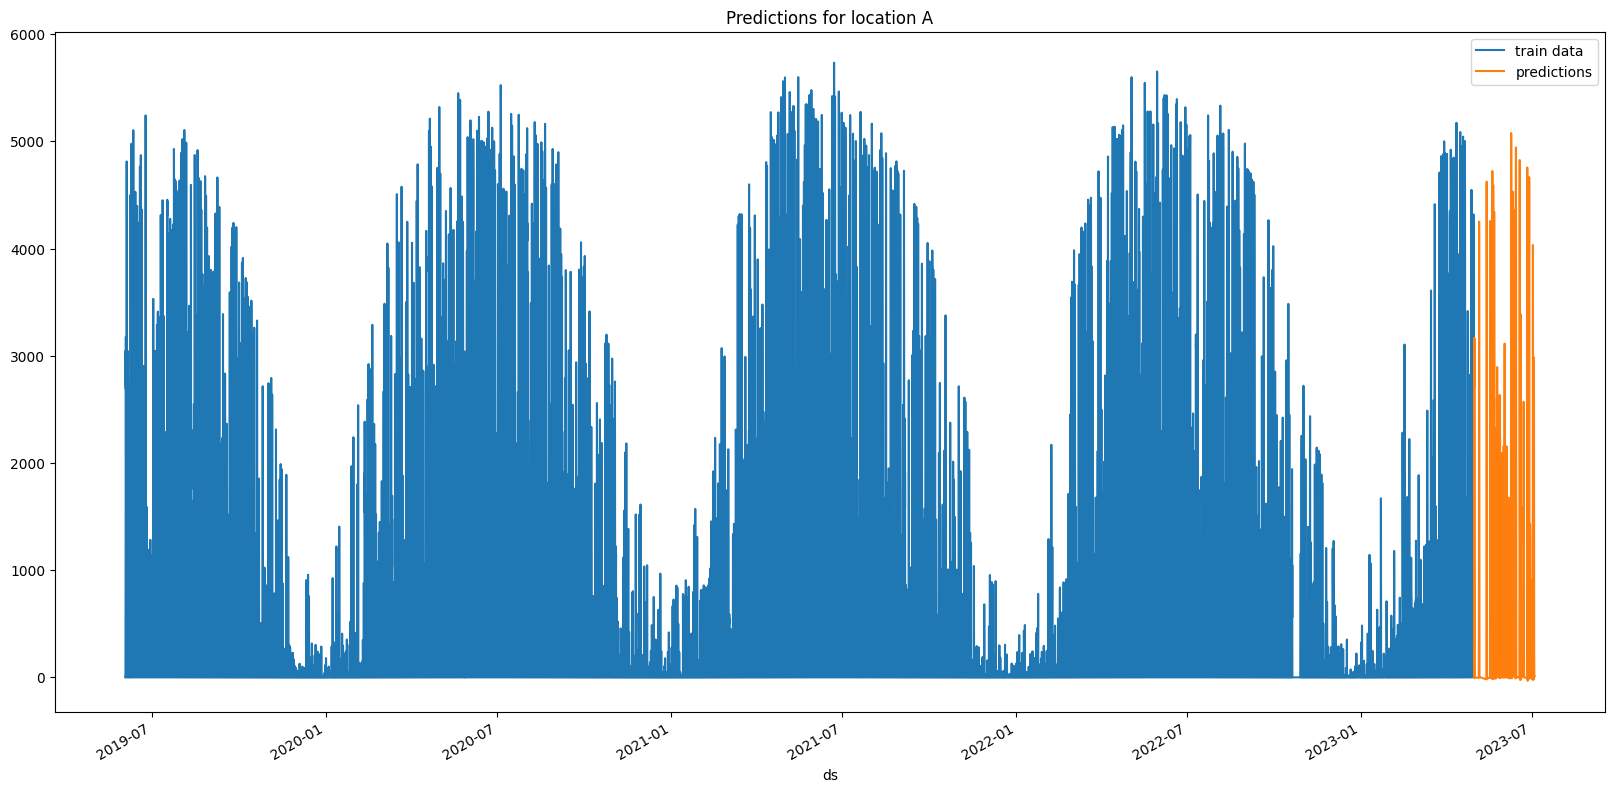

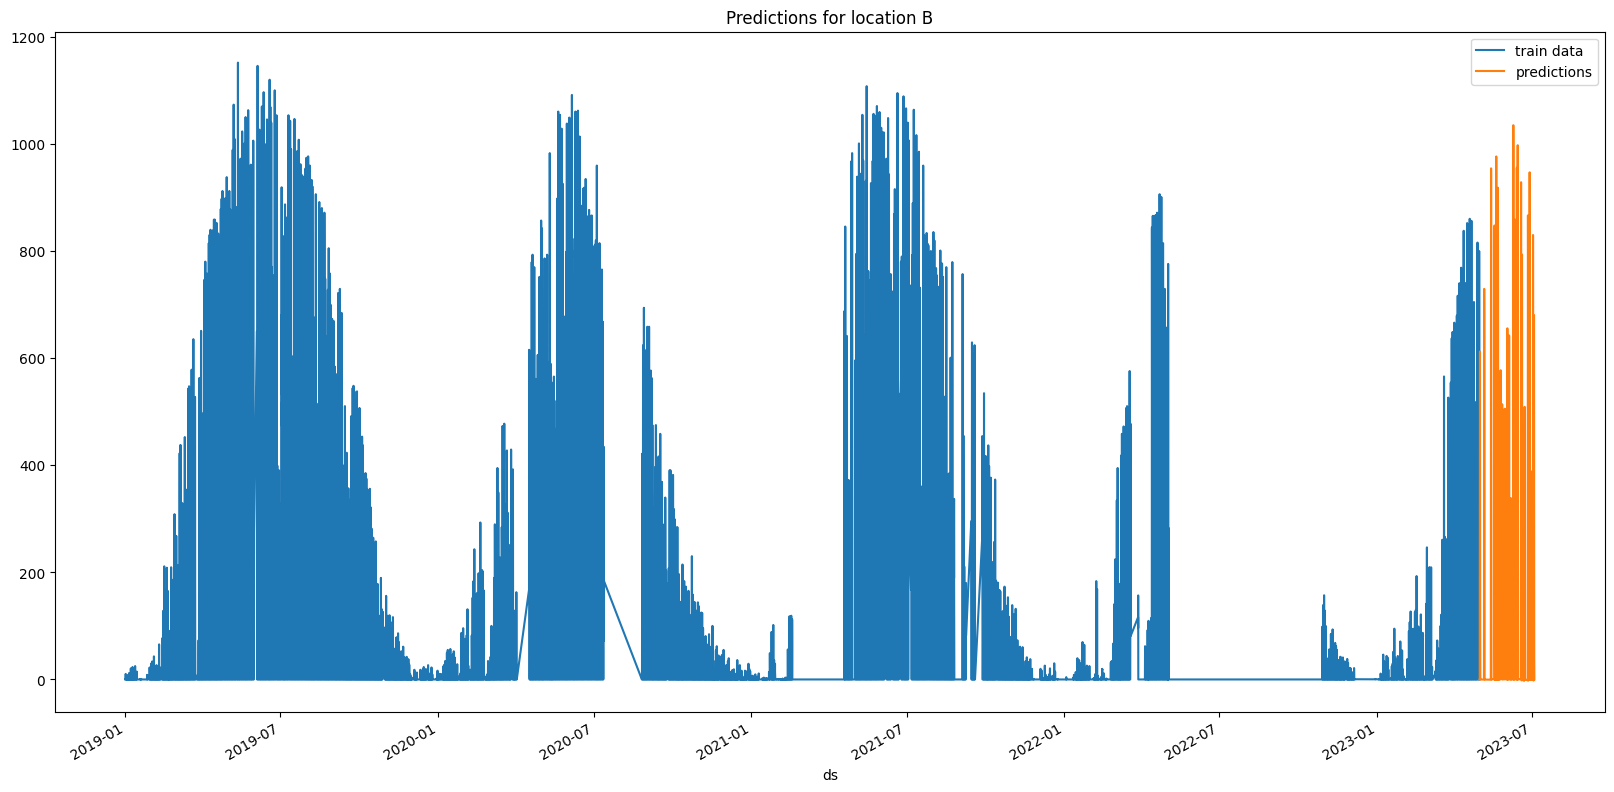

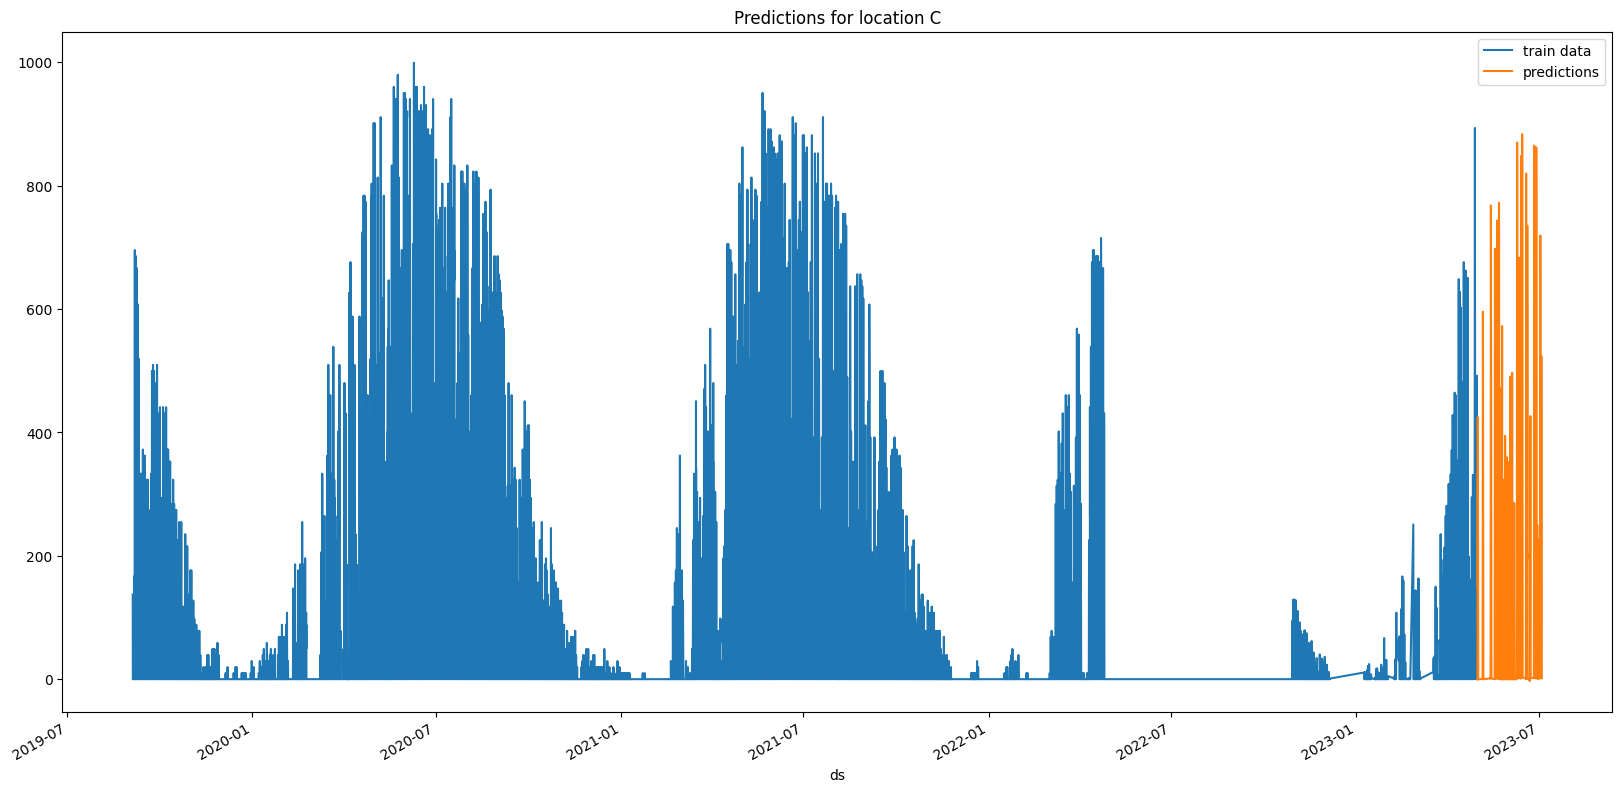

In [56]:
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_list[0][train_data_list[0]["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    ax.set_title(f"Predictions for location {loc}")

In [57]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())


# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -32.845566
Smallest prediction after clipping: 0.0
Smallest prediction: -2.5387175
Smallest prediction after clipping: 0.0
Smallest prediction: -2.7704537
Smallest prediction after clipping: 0.0


,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,23.171122
4,4,325.572723
...,...,...
715,2155,69.809311
716,2156,38.407642
717,2157,11.460097
718,2158,2.336670


In [58]:
# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_133.csv


In [59]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "short_2.ipynb"])

[NbConvertApp] Converting notebook short_2.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_133_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_133_files/notebook_pdfs
[NbConvertApp] Writing 226617 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 359128 bytes to notebook_pdfs/submission_133.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_133.pdf', 'short_2.ipynb'], returncode=0)